In [1]:
#Requirements:  1000 MKIDS on single readout line 
#               The bandwidth is 4-8 GHz
#               Smallest detectable wavelength is 402 nm
#               Q factor is constant on all frequencies
#               
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *
#%matplotlib widget
import kidcalc as kc # KID model
import SC # properties of superconducting materials

In [2]:
#Design parameters
N_MKIDs = 1000
N_read = int(1e3)
f0_A = 4.0037e9     #Hz resonance frequency A
f0_B = 4.004e9 #Hz resonance frequency B
kbT0 = 86.17 * .1 #µeV, operating temperature of 100 mK
hw0_A = 6.582e-4*2*np.pi*f0_A*1e-6 #Energy inherent in KID at fres
hw0_B = 6.582e-4*2*np.pi*f0_B*1e-6 #Energy inherent in KID at fres
Qi_sat = 1e16
Qc = 5.0e4     #Coupling quality factor
W_ind = 4 #Inductor width in µm
L_ind = 626 #Inductor length in µm
d_ind = 40e-3 #Inductor film thickness is µm
# V_ind = W_ind *L_ind * d_ind
V_ind = 15 # µm^3 inductor volume

supercond = SC.bTa() # material constants
ak = .96 # Kinetic Inductance fraction
beta = 2    #Thin film beta approximation
lmbda = 402 #nm, gives the max. E for the responsivity curve
etapb = .55 #Pair breaking efficiency 

print(V_ind)

15


In [3]:
dNqp = etapb * 6.528e-4*2*np.pi* 3e8 / (lmbda * 1e-3) / supercond.D0
Nqp0 = V_ind * kc.nqp(kbT0, supercond.D0, supercond)
kbTeff = kc.kbTeff((Nqp0 + dNqp)/V_ind, supercond)

def KID_eq_properties(hW0, D0, f0):
    s10, s20 = kc.cinduct(hW0, D0, kbT0)
    Qi_Nqp0 = 2/(ak*beta) * s20/s10
    Qi0 = Qi_Nqp0 * Qi_sat / (Qi_Nqp0 + Qi_sat)  #Physical systems have limited Qi
    Q0 = Qc * Qi0/ (Qc + Qi0)
    Lk0 = np.imag(1/(s10-1j*s20))/(2*np.pi*f0)
    C = ak/(f0**2*Lk0) 
    Lg = Lk0*(1/ak-1)
    return s10, s20, Qi0, Q0, Lk0, Lg, C

# calculate equilibrium complex conductivity, Qi, Lk and from that C and Lg (for later fres calc)
s10_A, s20_A, Qi0_A, Q0_A, Lk0_A, Lg_A, C_A = KID_eq_properties(hw0_A, supercond.D0, f0_A)
s10_B, s20_B, Qi0_B, Q0_B, Lk0_B, Lg_B, C_B = KID_eq_properties(hw0_B, supercond.D0, f0_B)

def dB_scale(signal):
    dB_signal = 10*np.log10(np.abs(signal))
    return dB_signal

#Define frequency range of interest 
f_read_min = f0_B - 8*f0_B/Q0_B
f_read_max = f0_B + 4*f0_B/Q0_B
f_read = np.linspace(f_read_min, f_read_max, N_read)
f_dis = 0.3e6

print(Qi0_A*Qc/(Qi0_A+Qc))
print(Qi0_B*Qc/(Qi0_B+Qc))
print(kbTeff)

49964.13862919989
49964.13881552118
16.336534244890245


In [4]:
#calculate complex conductivities and excess quasiparticles during pulse (between kbT0 and kbTeff)
kbTarr = np.logspace(np.log10(kbT0), np.log10(kbTeff), N_read)
s1_A, s2_A, exNqp = np.zeros((3, len(kbTarr)))
for i, kbT in enumerate(kbTarr):
    s1_A[i], s2_A[i] = kc.cinduct(hw0_A, supercond.D0, kbT)
    exNqp[i] = V_ind * kc.nqp(kbT, supercond.D0, supercond)

s1_B, s2_B = np.zeros((2, len(kbTarr)))
for i, kbT in enumerate(kbTarr):
    s1_B[i], s2_B[i] = kc.cinduct(hw0_B, supercond.D0, kbT)

In [5]:
def KID_dark(Qi0, Qc, f_read, f0, s1, s2, Lg, C):
    S21_0 = kc.S21(Qi0, Qc, f_read, f0)
    Lk = np.imag(1/(s1-1j*s2))/(2*np.pi*f0)
    f_resp = 1/np.sqrt(C*(Lk + Lg))
    Qi_resp = (2*s2)/(ak*beta*s1)
    Q_resp = Qc * Qi_resp / (Qc + Qi_resp)
    return S21_0, Lk, f_resp, Qi_resp, Q_resp

S21_0_A, Lk_A, f_resp_A, Qi_resp_A, Q_resp_A = KID_dark(Qi0_A, Qc, f_read, f0_A, s1_A, s2_A, Lg_A, C_A)
S21_0_B, Lk_B, f_resp_B, Qi_resp_B, Q_resp_B = KID_dark(Qi0_B, Qc, f_read, f0_B, s1_B, s2_B, Lg_B, C_B)

S21_resp_B = kc.S21(min(Qi_resp_B), Qc, f_read, min(f_resp_B))
S21_prod = S21_0_A*S21_0_B

In [6]:
def interact_S21():
    ## Set up the plot data
    fig   = plt.figure(figsize=(8,3))
    plt.plot(f_read,10*np.log10(np.abs(S21_prod)), linewidth=1, label="Unloaded S21")
    line, = plt.plot([], [], linewidth=2, label="Loaded S21", color = "indianred")# Initialize curve to empty data.

    ## Set up the figure axes, etc.
    plt.title(r"Varying $T_{eff}$")
    plt.xlim(min(f_read), max(f_read))
    plt.ylim(-40, 0.1)
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('S21 (dB)')
    plt.legend()
    plt.close()      # Don't show the figure yet.

    ## Callback function
    def plot_S21(kbT_slider,f_dis_slider):
        s1_resp_B, s2_resp_B = kc.cinduct(hw0_B, supercond.D0, kbT_slider)
        Lk_resp_B = np.imag(1/(s1_resp_B-1j*s2_resp_B))/(2*np.pi*f0_B)
        f_resp_B = 1/np.sqrt(C_B*(Lk_resp_B + Lg_B))
        Qi_resp_B = (2*s2_resp_B)/(ak*beta*s1_resp_B)
        S21_resp_B = kc.S21(Qi_resp_B, Qc, f_read, f_resp_B)
        S21_A = kc.S21(Qi0_A, Qc, f_read, f0_A+f_dis_slider)
        line.set_data(f_read, 10*np.log10(np.abs(S21_resp_B*S21_A)))
        display(fig)
        

    ## Generate the user interface.
    interact(plot_S21, 
             kbT_slider=FloatSlider(min=min(kbTarr), max=1.1*max(kbTarr), step=0.1, value=kbT0, description = "kbT"),
             f_dis_slider = FloatSlider(min =0 , max = 1.2*f_dis, step = 1e4, value = 0, description = "f_shift"))

interact_S21();


interactive(children=(FloatSlider(value=8.617, description='kbT', max=17.970187669379268, min=8.617), FloatSli…

4004000000.0
4003999999.519999
4003999999.0347266
4003999998.544068
4003999998.0480165
4003999997.546462
4003999997.0393887
4003999996.5267644
4003999996.0084805
4003999995.484513
4003999994.9547405
4003999994.4191966
4003999993.8777075
4003999993.3303194
4003999992.776969
4003999992.217467
4003999991.6519337
4003999991.080135
4003999990.5021567
4003999989.917822
4003999989.327103
4003999988.729966
4003999988.1263075
4003999987.516028
4003999986.899201
4003999986.275555
4003999985.6452017
4003999985.0079827
4003999984.363817
4003999983.7126713
4003999983.054502
4003999982.389127
4003999981.716559
4003999981.0367193
4003999980.349593
4003999979.654994
4003999978.9528375
4003999978.2431855
4003999977.525833
4003999976.800765
4003999976.0679193
4003999975.3270893
4003999974.5783844
4003999973.821541
4003999973.056677
4003999972.283496
4003999971.502055
4003999970.712301
4003999969.9140153
4003999969.10717
4003999968.2917147
4003999967.4675603
4003999966.634525
4003999965.7926745
400399996

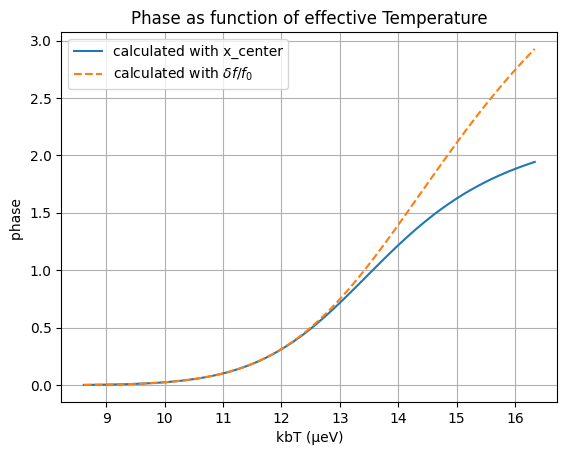

In [7]:
def phase_response_xc(s1_eff, s2_eff):
    S21_dark = kc.S21(Qi0_B, Qc, f_read, f0_B)
    f_res_index = np.argmin(dB_scale(S21_dark))
    phase_dark = np.imag(S21_dark)[f_res_index]
    phase_resp = np.zeros(len(s1_eff))
    theta = np.zeros(len(s1_eff))
    # x_center = (1 + np.min(dB_scale(S21_dark))/2)

    for i in range(len(s1_eff)):
        Lk_resp = np.imag(1/(s1_eff[i]-1j*s2_eff[i]))/(2*np.pi*f0_B)
        f_resp = 1/np.sqrt(C_B*(Lk_resp + Lg_B))
        Qi_resp = (2*s2_eff[i])/(ak*beta*s1_eff[i])
        S21_resp = kc.S21(Qi_resp, Qc, f_read, f_resp)
        circle_Im0 = np.min(np.real(S21_resp))
        x_center = (1 + circle_Im0)/2
        theta[i] = np.arctan2(S21_resp.imag[f_res_index], x_center - S21_resp.real[f_res_index])
        phase_resp[i] = (S21_resp.imag[f_res_index])/(x_center-S21_resp.real[f_res_index])
    return theta#, S21_dark

def phase_response_df(s1_eff, s2_eff):
    S21_dark = kc.S21(Qi0_B, Qc, f_read, f0_B)
    f_res_index = np.argmin(dB_scale(S21_dark))
    phase_dark = np.imag(S21_dark)[f_res_index]
    phase_resp = np.zeros(len(s1_eff))
    for i in range(len(s1_eff)):
        Lk_resp = np.imag(1/(s1_eff[i]-1j*s2_eff[i]))/(2*np.pi*f0_B)
        f_resp = 1/np.sqrt(C_B*(Lk_resp + Lg_B))
        Qi_resp = (2*s2_eff[i])/(ak*beta*s1_eff[i])
        Q_resp = Qc * Qi_resp / (Qc + Qi_resp)
        phase_resp[i] =  -4*Q_resp * (f_resp-f_read[f_res_index])/f_read[f_res_index]
    return phase_resp

# plt.plot(phase_response_xc(s1_B, s2_B)[1].real, phase_response_xc(s1_B, s2_B)[1].imag)

phase_xc = phase_response_xc(s1_B, s2_B)
phase_df = phase_response_df(s1_B, s2_B)

plt.plot(kbTarr, phase_xc, label = 'calculated with x_center')
plt.plot(kbTarr, phase_df, label = r"calculated with $\delta f/f_0$", linestyle = "dashed")
plt.title("Phase as function of effective Temperature")
plt.xlabel("kbT (µeV)")
plt.ylabel("phase ")
plt.legend()
plt.grid()

# print(kbTarr[np.argmin(phase_xc)])

In [8]:
def interact_circle():
    ## Set up the plot data
    fig   = plt.figure(figsize=(5,5))
    # plt.plot(f_read,10*np.log10(np.abs(S21_0*S21_1)), linewidth=1, label="Unloaded S21")
    line, = plt.plot([], [], linewidth=2, label="Loaded S21", color = "indianred")# Initialize curve to empty data.

    ## Set up the figure axes, etc.
    plt.title("Resonance circle")
    plt.vlines(1, -1,1)
    plt.xlim(0, 2)
    plt.ylim(-1, 1)
    plt.xlabel('Re(S21)')
    plt.ylabel('Im(S21)')
    plt.legend()
    plt.close()      # Don't show the figure yet.

    ## Callback function
    def plot_circle(kbT_slider,f_dis_slider):
        s1_resp, s2_resp = kc.cinduct(hw0_B, supercond.D0, kbT_slider)
        Lk_resp = np.imag(1/(s1_resp-1j*s2_resp))/(2*np.pi*f0_B)
        f_resp = 1/np.sqrt(C_B*(Lk_resp + Lg_B))
        Qi_resp = (2*s2_resp)/(ak*beta*s1_resp)
        S21_resp = kc.S21(Qi_resp, Qc, f_read, f_resp)
        # S21_1_var = kc.S21(Qi0_B, Qc, f_read, f0_B-f_dis_slider)
        # S21_combined = S21_resp + S21_1_var
        line.set_data(np.real(S21_resp), np.imag(S21_resp))
        display(fig)
        

    ## Generate the user interface.
    interact(plot_circle, 
             kbT_slider=FloatSlider(min=min(kbTarr), max=1.1*max(kbTarr), step=0.1, value=kbT0, description = r"T_eff"),
             f_dis_slider = FloatSlider(min =1e3 , max = f_dis, step = 1e4, value = f_dis, description = "f_shift"))

interact_circle();

interactive(children=(FloatSlider(value=8.617, description='T_eff', max=17.970187669379268, min=8.617), FloatS…

In [ ]:
for count, val in enumerate(S21_resp_B):
    if np.abs(val) == min(np.abs(S21_resp_B)):
        print(f_read[count])
        print("Highest shift:",(f0_B - f_read[count])/1e6, "MHz")


S21_resp_B_min = min(Q_resp_B)/min(Qi_resp_B)
print(10*np.log10(np.abs(S21_resp_B_min)))

In [ ]:
#Calculating magnitude of frequency collisions in dB
S21_0min_B =10*np.log10(np.abs(Q0_B/Qi0_B))  

def calc_collision(s1, s2):

   #Find the index of the resonance frequency where crosstalk is measured
   index_f0_A = np.argmin(np.abs(np.array(f_read)-f0_A))
   crosstalk_array = np.zeros(N_read)

   #Calculate response at resonance of stationary KID
   for i in range(N_read):
      Lk_resp_B_i = np.imag(1/(s1[i]-1j*s2[i]))/(2*np.pi*f0_B)
      f_resp_B_i = 1/np.sqrt(C_B*(Lk_resp_B_i + Lg_B))
      Qi_resp_i = (2*s2[i])/(ak*beta*s1[i]) 
      S21_resp_i = 10*np.log10(np.abs(kc.S21(Qi_resp_i, Qc, f_read, f_resp_B_i)))
      crosstalk_array[i] = S21_resp_i[index_f0_A]

   return crosstalk_array


coll = calc_collision(s1_B, s2_B)


plt.plot(kbTarr, coll, label = "Frequency collision magnitude")
plt.title("Frequency collisions between 2 KIDs 0.3 MHz apart")
plt.ylabel("Magnitude (dB)")
plt.xlabel("Effevtive temperature (kbT)")
plt.vlines(16.336, -1.1, 0, linestyles= "dashed", color = "black", label= "kbT at 402nm")
plt.legend()

In [ ]:
FWHM = f0_B/Q0_B

def Jochem_calc_collision(f_shift, S21_stat):
    f0_index = np.argmin(dB_scale(S21_stat))
    collision_array = np.zeros(len(f_shift))

    for i in range(len(f_shift)):
        S21_shift = kc.S21(Qi0_A, Qc, f_read, f0_A+f_shift[i])
        collision_array[i] = S21_shift[f0_index]-  S21_stat[f0_index]
 
    return collision_array

f_shift = np.linspace(0.3e6,3e6, N_read)
    
coll = Jochem_calc_collision(f_shift, S21_0_B)
    
plt.plot((f_shift-min(f_shift))/FWHM, 1-coll)
plt.xlabel("Shift in f_res (# of FWHM)")
plt.ylabel("'crosstalk' level")
plt.title("Frequency collision of 2 identical MKIDs")
plt.yscale("log")
plt.grid()

In [ ]:
plt.close()
plt.plot(f_read,np.imag(S21_prod))
plt.show()